# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para hosts pessoas físicas

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita um host pessoa física que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### Créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro no dia 15/10/21.

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas e Bases de Dados

In [1]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split

In [2]:
caminho_bases = pathlib.Path('dataset') # local onde estão os datasets

base_airbnb_df = pd.DataFrame() # dataset vazio onde serão incluídos os datasets

# dicionário para incluir a coluna do mês no df com o respectivo número
meses = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

# percorrer cada arquivo na pasta datasets
for arquivo in caminho_bases.iterdir():
    mes = meses[arquivo.name[0:3]] # pega o mês no nome do arquivo
    ano = int(arquivo.name[-8:-4]) # pega o ano no nome do arquivo
    df = pd.read_csv(caminho_bases / arquivo.name) # cada df é lido pelo pandas
    df['mes'] = mes # inclui colua mês
    df['ano'] = ano # inclui coluna ano
    base_airbnb_df = base_airbnb_df.append(df) #inclui cada df com coluna mês e ano em uma única base
    

C:\Users\Micro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (62,87) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\Micro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (61,62,94) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\Micro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (87) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
display(base_airbnb_df)

id                            listing_url       scrape_id  \
0         14063     https://www.airbnb.com/rooms/14063  20180414160018   
1         17878     https://www.airbnb.com/rooms/17878  20180414160018   
2         24480     https://www.airbnb.com/rooms/24480  20180414160018   
3         25026     https://www.airbnb.com/rooms/25026  20180414160018   
4         31560     https://www.airbnb.com/rooms/31560  20180414160018   
...         ...                                    ...             ...   
34324  38844730  https://www.airbnb.com/rooms/38844730  20190923212307   
34325  38846408  https://www.airbnb.com/rooms/38846408  20190923212307   
34326  38846703  https://www.airbnb.com/rooms/38846703  20190923212307   
34327  38847050  https://www.airbnb.com/rooms/38847050  20190923212307   
34328  38847655  https://www.airbnb.com/rooms/38847655  20190923212307   

      last_scraped                                          name  \
0       2018-04-14                          Living in a Postcard   
1       2018-04-14             Very Nice 2Br - Copacabana - WiFi   
2       2018-04-14              Nice and cozy near Ipanema Beach   
3       2018-04-14     Beautiful Modern Decorated Studio in Copa   
4       2018-04-14              NICE & COZY 1BDR - IPANEMA BEACH   
...            ...                                           ...   
34324   2019-09-24             TRANSAMERICA BARRA DA TIJUCA R IV   
34325   2019-09-24                      Alugo para o Rock in Rio   
34326   2019-09-24  Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA   
34327   2019-09-24                     Cobertura Cinematografica   
34328   2019-09-24     Quarto em cobertura em frente à praia III   

                                                 summary  \
0      Besides the most iconic's view, our apartment ...   
1      Please note that special rates apply for New Y...   
2      My studio is located in the best  of Ipanema. ...   
3      Our apartment is a little gem, everyone loves ...   
4      This nice and clean 1 bedroom apartment is loc...   
...                                                  ...   
34324  Em estilo contemporâneo, o Transamerica Prime ...   
34325  Confortável apartamento, 2 quartos , sendo 1 s...   
34326  Apartamento quarto e sala COMPLETO para curtas...   
34327                               Cobertura alto nivel   
34328  Quarto em cobertura quadriplex com vista lindí...   

                                                   space  \
0                                                    NaN   
1      - large balcony which looks out on pedestrian ...   
2      The studio is located at Vinicius de Moraes St...   
3      This newly renovated studio (last renovations ...   
4      This nice and clean 1 bedroom apartment is loc...   
...                                                  ...   
34324                                                NaN   
34325  O apartamento estará com mobília completa disp...   
34326  Espaço ideal para até 5 pessoas. Cama de casal...   
34327                                                NaN   
34328                                                NaN   

                                             description experiences_offered  \
0      Besides the most iconic's view, our apartment ...                none   
1      Please note that special rates apply for New Y...                none   
2      My studio is located in the best  of Ipanema. ...                none   
3      Our apartment is a little gem, everyone loves ...                none   
4      This nice and clean 1 bedroom apartment is loc...                none   
...                                                  ...                 ...   
34324  Em estilo contemporâneo, o Transamerica Prime ...                none   
34325  Confortável apartamento, 2 quartos , sendo 1 s...                none   
34326  Apartamento quarto e sala COMPLETO para curtas...                none   
34327                               Cobertura alto nivel         

### Consolidar Base de Dados

- Verificar que colunas podem ser retiradas para limpar a base

In [4]:
print(list(base_airbnb_df.columns)) # lista com as colunas

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

### Se tivermos muitas colunas, já vamos identificar quais colunas podemos excluir

- Para facilitar a análise de quais colunas podem ser retiradas sem afetar a análise, exportaremos um arquivo CSV com algumas linhas para verificar quais colunas podem ser deletadas

In [5]:
base_airbnb_df.head(100).to_csv('primeiros_registros.csv', sep=';')

Analisando a base conclui que é possível retirar as seguintes colunas:

- IDs, Links e informações não relevantes para o modelo
- Colunas repetidas ou extremamente parecidas com outra (que dão a mesma informação para o modelo. Ex: Data x Ano/Mês
- Colunas preenchidas com texto livre -> Não rodaremos nenhuma análise de palavras ou algo do tipo
- Colunas em que todos ou quase todos os valores são iguais

### Depois da análise qualitativa das colunas, ficamos com as seguintes colunas:

In [6]:
colunas = ['host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'mes', 'ano']

In [7]:
base_airbnb_df = base_airbnb_df.loc[:, colunas] # retirando as colunas que não vamos utilizar na análise

In [8]:
display(base_airbnb_df)

host_response_time host_response_rate host_is_superhost  \
0                     NaN                NaN                 f   
1          within an hour               100%                 t   
2          within an hour               100%                 f   
3          within an hour               100%                 f   
4          within an hour               100%                 t   
...                   ...                ...               ...   
34324      within an hour                93%                 f   
34325                 NaN                NaN                 f   
34326  within a few hours                74%                 f   
34327                 NaN                NaN                 f   
34328  a few days or more                38%                 f   

       host_listings_count   latitude  longitude property_type  \
0                      1.0 -22.946854 -43.182737     Apartment   
1                      2.0 -22.965919 -43.178962   Condominium   
2                      1.0 -22.985698 -43.201935     Apartment   
3                      3.0 -22.977117 -43.190454     Apartment   
4                      1.0 -22.983024 -43.214270     Apartment   
...                    ...        ...        ...           ...   
34324                  0.0 -23.003180 -43.342840     Apartment   
34325                  0.0 -22.966640 -43.393450     Apartment   
34326                 32.0 -22.962080 -43.175520     Apartment   
34327                  0.0 -23.003400 -43.341820     Apartment   
34328                  5.0 -23.010560 -43.363350     Apartment   

             room_type  accommodates  bathrooms  ...  \
0      Entire home/apt             4        1.0  ...   
1      Entire home/apt             5        1.0  ...   
2      Entire home/apt             2        1.0  ...   
3      Entire home/apt             3        1.0  ...   
4      Entire home/apt             3        1.0  ...   
...                ...           ...        ...  ...   
34324  Entire home/apt             4        1.0  ...   
34325  Entire home/apt             4        2.0  ...   
34326  Entire home/apt             5        1.0  ...   
34327  Entire home/apt             4        1.0  ...   
34328     Private room             2        0.0  ...   

       review_scores_cleanliness  review_scores_checkin  \
0                            9.0                    9.0   
1                            9.0                   10.0   
2                           10.0                   10.0   
3                           10.0                   10.0   
4                           10.0                   10.0   
...                          ...                    ...   
34324                        NaN                    NaN   
34325                        NaN                    NaN   
34326                        NaN                    NaN   
34327                        NaN                    NaN   
34328                        NaN                    NaN   

      review_scores_communication review_scores_location review_scores_value  \
0                             9.0                    9.0                 9.0   
1                            10.0                    9.0                 9.0   
2                            10.0                   10.0                 9.0   
3                            10.0                   10.0                 9.0   
4                            10.0                   10.0                 9.0   
...                           ...                    ...                 ...   
34324                         NaN                    NaN                 NaN   
34325                         NaN                    NaN                 NaN   
34326                         NaN                    NaN                 NaN   
34327                         NaN                    NaN                 NaN   
34328                         NaN                    NaN                 NaN   

      instant_bookable is_business_travel_ready          cancellation_policy  

In [9]:
print(list(base_airbnb_df.columns)) # lista com as colunas que vão ser analisadas

['host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'mes', 'ano']


### Tratar Valores Faltando

In [10]:
print(base_airbnb_df.isnull().sum())

host_response_time             401843
host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650
review_score

- As colunas 'host_response_time', 'host_response_rate', 'security_deposit', 'cleaning_fee' e reviews, possuem muitos valores vazios então não vou utilizá-las.
- As colunas 'host_is_superhost', 'host_listings_count', 'bathrooms', 'bdrooms' e 'beds' possuem poucos valores faltantes (entre 0,05% e 0,2% da base) então vou excluir.

In [11]:
base_airbnb_df = base_airbnb_df.drop(labels = ['host_response_time', 'host_response_rate','review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value','security_deposit','cleaning_fee'], axis = 1)

In [12]:
base_airbnb_df = base_airbnb_df.fillna(value={'security_deposit':0, 'cleaning_fee':0})

In [13]:
base_airbnb_df = base_airbnb_df.dropna()

In [14]:
print(base_airbnb_df.isnull().sum())

host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
mes                         0
ano                         0
dtype: int64


In [15]:
print(base_airbnb_df.shape)

(897709, 23)


### Verificar Tipos de Dados em cada coluna

In [16]:
base_airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 897709 entries, 0 to 34328
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   host_is_superhost         897709 non-null  object 
 1   host_listings_count       897709 non-null  float64
 2   latitude                  897709 non-null  float64
 3   longitude                 897709 non-null  float64
 4   property_type             897709 non-null  object 
 5   room_type                 897709 non-null  object 
 6   accommodates              897709 non-null  int64  
 7   bathrooms                 897709 non-null  float64
 8   bedrooms                  897709 non-null  float64
 9   beds                      897709 non-null  float64
 10  bed_type                  897709 non-null  object 
 11  amenities                 897709 non-null  object 
 12  price                     897709 non-null  object 
 13  guests_included           897709 non-null  in

- Preço, taxa de limpeza, deposito de segurança e pessoas extras estão sendo reconhecidos como objeto ao invés de float, precisamos mudar a variável da coluna.

In [17]:
#price
base_airbnb_df['price'] = base_airbnb_df['price'].str.replace('$','')
base_airbnb_df['price'] = base_airbnb_df['price'].str.replace(',','')
base_airbnb_df['price'] = base_airbnb_df['price'].astype(np.float32, copy=False)
#extra_people
base_airbnb_df['extra_people'] = base_airbnb_df['extra_people'].str.replace('$','')
base_airbnb_df['extra_people'] = base_airbnb_df['extra_people'].str.replace(',','')
base_airbnb_df['extra_people'] = base_airbnb_df['extra_people'].astype(np.float32, copy=False)

<ipython-input-17-c9fa85774bed>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  base_airbnb_df['price'] = base_airbnb_df['price'].str.replace('$','')
<ipython-input-17-c9fa85774bed>:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  base_airbnb_df['extra_people'] = base_airbnb_df['extra_people'].str.replace('$','')


In [18]:
base_airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 897709 entries, 0 to 34328
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   host_is_superhost         897709 non-null  object 
 1   host_listings_count       897709 non-null  float64
 2   latitude                  897709 non-null  float64
 3   longitude                 897709 non-null  float64
 4   property_type             897709 non-null  object 
 5   room_type                 897709 non-null  object 
 6   accommodates              897709 non-null  int64  
 7   bathrooms                 897709 non-null  float64
 8   bedrooms                  897709 non-null  float64
 9   beds                      897709 non-null  float64
 10  bed_type                  897709 non-null  object 
 11  amenities                 897709 non-null  object 
 12  price                     897709 non-null  float32
 13  guests_included           897709 non-null  in

### Análise Exploratória e Tratar Outliers

- Vamos basicamente olhar feature por feature para:
    1. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
    2. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1 (Não saia excluindo direto outliers. Se não tem um motivo claro para remover o outlier, talvez não seja necessário e pode ser prejudicial para a generalização.)
    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir
    
- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.

- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)

- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

Como o objetivo é ajudar a precificar um imóvel que você está querendo disponibilizar, excluir outliers em host_listings_count pode fazer sentido.

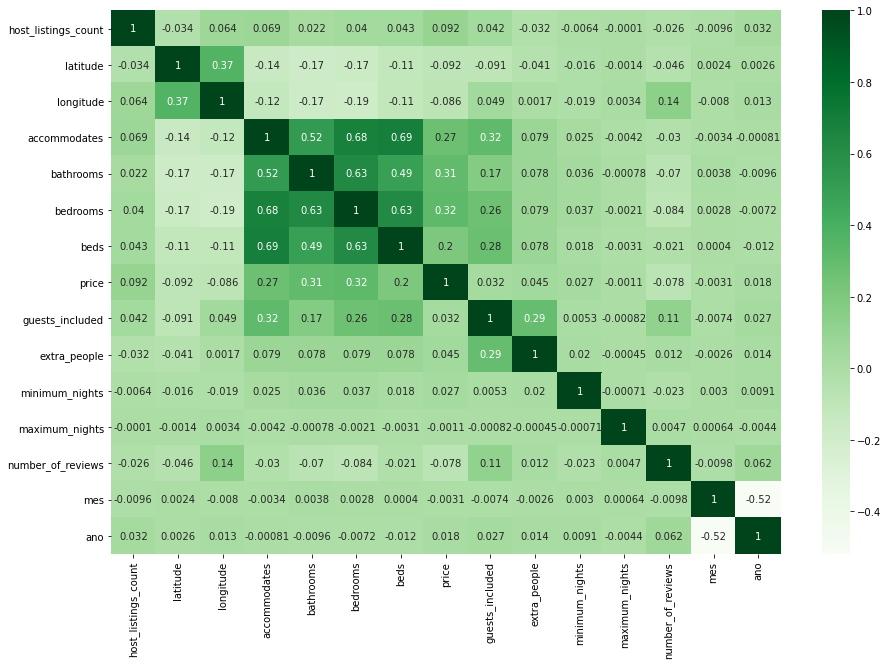

In [20]:
plt.figure(figsize = (15, 10))
sns.heatmap(base_airbnb_df.corr(), annot = True, cmap='Greens')
plt.show()

### Definição de Funções para Análise de Outliers

Definindo algumas funções para ajudar na análise de outliers das colunas

In [21]:
def limites(coluna):
    q1 = coluna.quantile(0.25) # primeiro quartil
    q3 = coluna.quantile(0.75) # terceiro quartil
    amplitude = q3 - q1
    return (q1 - 1.5 * amplitude, q3 + 1.5 * amplitude)

In [22]:
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2) # divide em dois gráficos lado a lado
    fig.set_size_inches(15,5) # acerta o tamanho
    sns.boxplot(x= coluna, ax= ax1) # plota o 1 gráfico
    ax2.set_xlim(limites(coluna)) # define o limite máximo para o 2 gráfico
    sns.boxplot(x= coluna, ax= ax2) # plota o 2 gráfico

In [23]:
def histograma(coluna):
    plt.figure(figsize = (15, 5)) # acerta o tamanho
    sns.distplot(coluna, hist=True) #plota o gráfico
    plt.show()

In [24]:
def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0] #quantidade de linhas antes de remover 
    lim_inf, lim_sup = limites(df[nome_coluna]) # criando variáveis dos limites inferior e superior
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup),:] # excluindo do dataframe
    linhas_removidas = qtde_linhas - df.shape[0] # contando quantas linhas foram removidas
    return df, linhas_removidas

In [25]:
def grafico_barra(coluna):
    plt.figure(figsize = (15, 5)) # acerta o tamanho
    ax = sns.barplot(x = coluna.value_counts().index, y = coluna.value_counts()) #plota o gráfico
    ax.set_xlim(limites(coluna))
    plt.show()

#### price

C:\Users\Micro\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


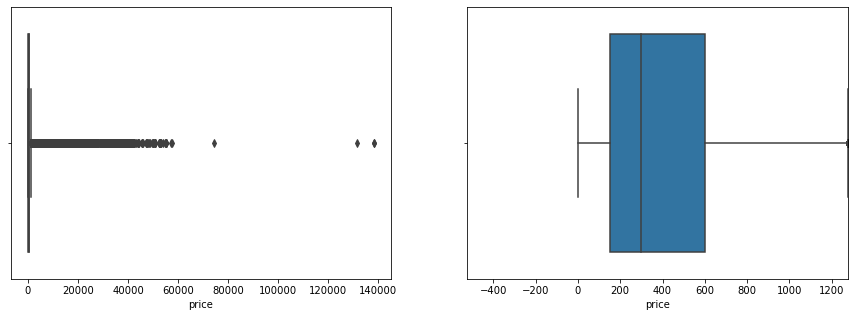

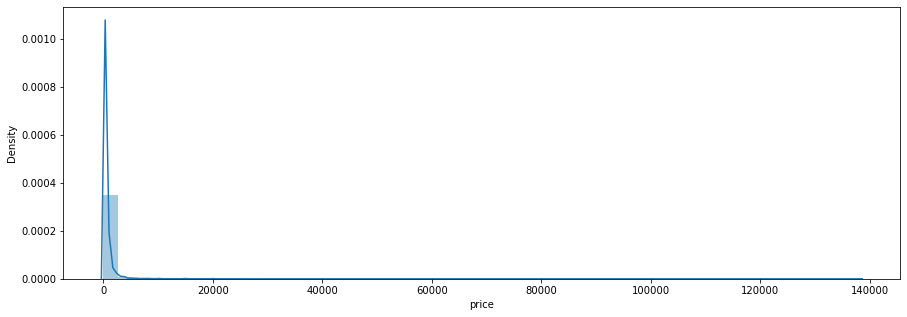

In [26]:
diagrama_caixa(base_airbnb_df['price'])
histograma(base_airbnb_df['price'])

In [27]:
base_airbnb_df, linhas_removidas = excluir_outliers(base_airbnb_df, 'price') #removendo outliers

In [28]:
print('{} linhas removidas'.format(linhas_removidas))

87282 linhas removidas


C:\Users\Micro\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


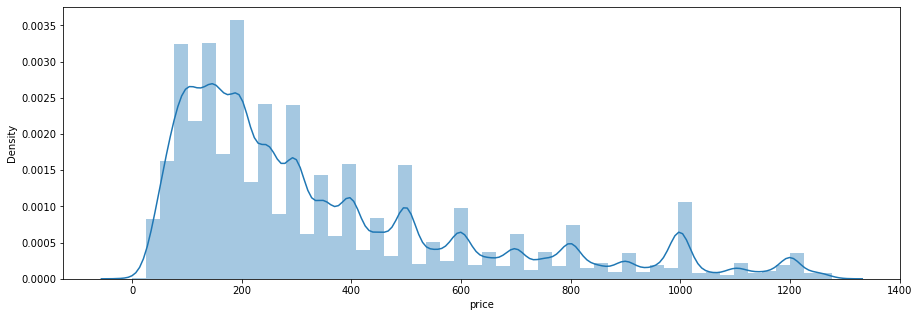

(810427, 23)


In [29]:
histograma(base_airbnb_df['price'])
print(base_airbnb_df.shape)

#### extra_people

C:\Users\Micro\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


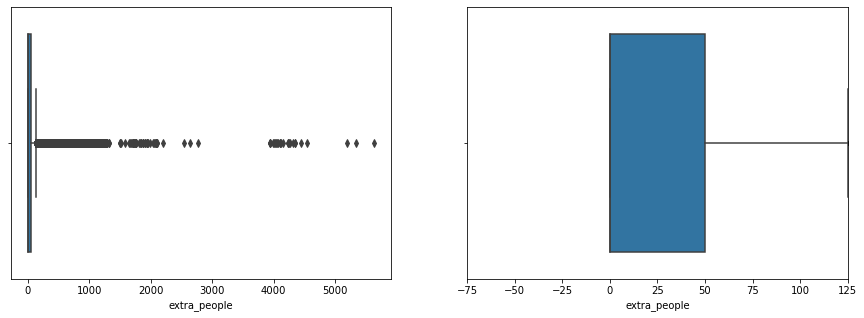

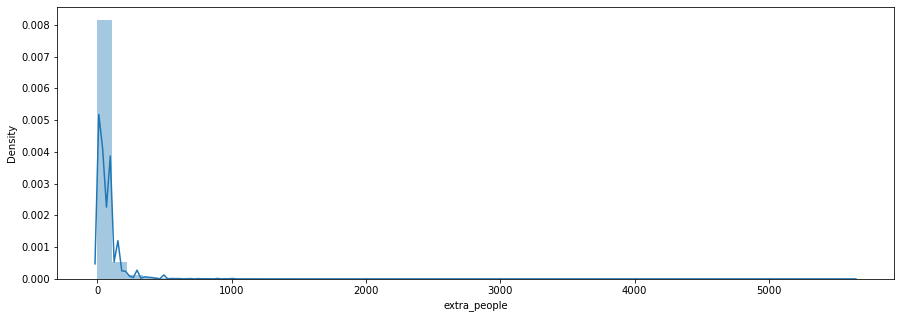

In [30]:
diagrama_caixa(base_airbnb_df['extra_people'])
histograma(base_airbnb_df['extra_people'])

In [31]:
base_airbnb_df, linhas_removidas = excluir_outliers(base_airbnb_df, 'extra_people') #removendo outliers

In [32]:
print('{} linhas removidas'.format(linhas_removidas))

59194 linhas removidas


C:\Users\Micro\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


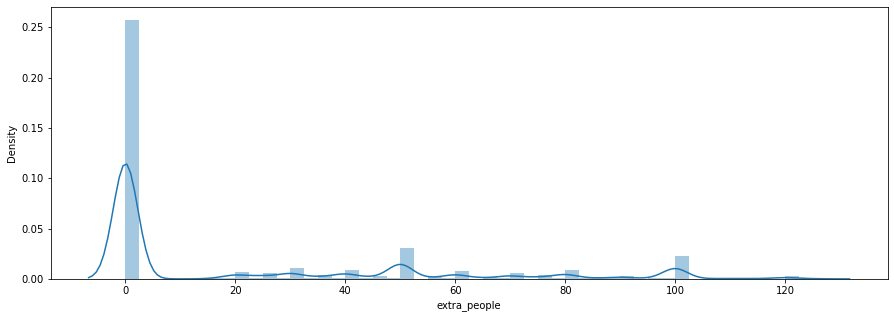

(751233, 23)


In [33]:
histograma(base_airbnb_df['extra_people'])
print(base_airbnb_df.shape)

#### host_listings_count

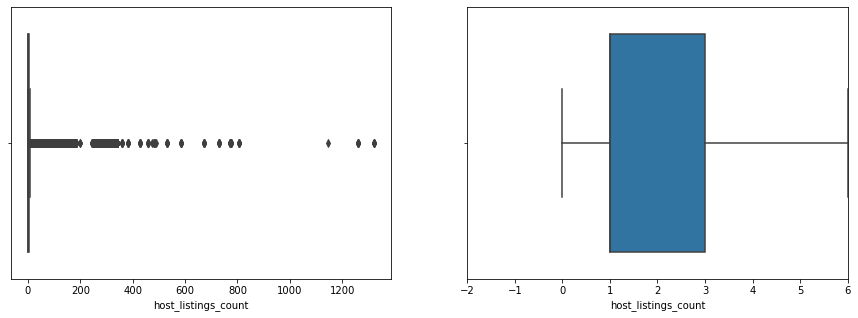

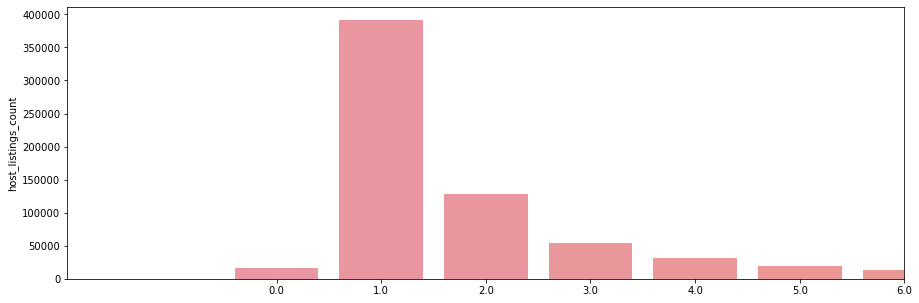

In [34]:
diagrama_caixa(base_airbnb_df['host_listings_count'])
grafico_barra(base_airbnb_df['host_listings_count'])

In [35]:
base_airbnb_df, linhas_removidas = excluir_outliers(base_airbnb_df, 'host_listings_count') #removendo outliers

In [36]:
print('{} linhas removidas'.format(linhas_removidas))

97723 linhas removidas


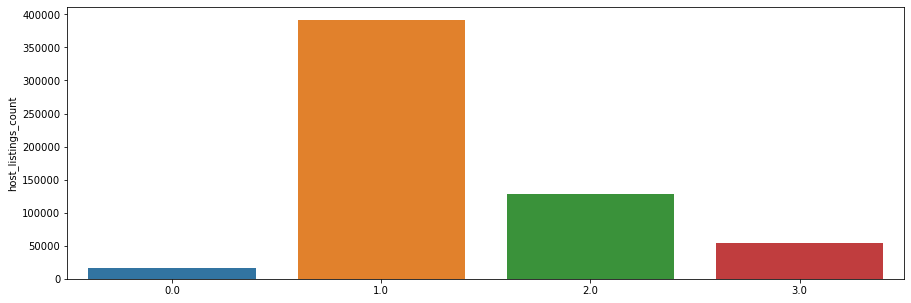

(653510, 23)


In [37]:
grafico_barra(base_airbnb_df['host_listings_count'])
print(base_airbnb_df.shape)

#### accommodates

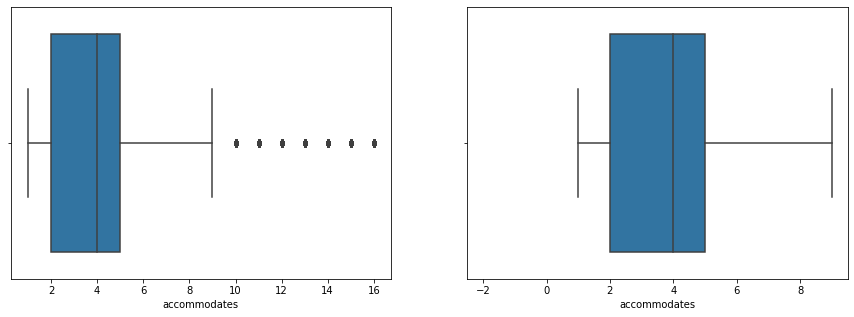

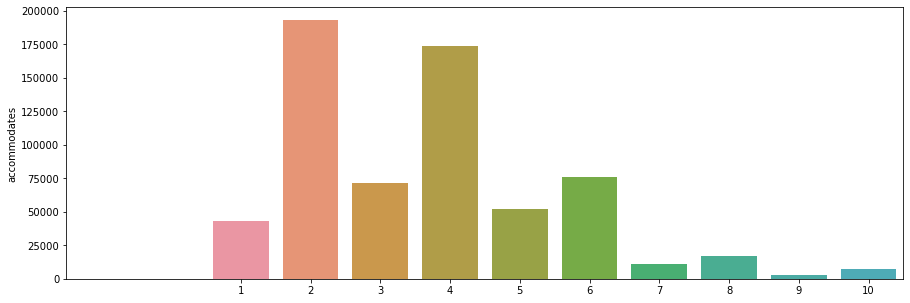

In [38]:
diagrama_caixa(base_airbnb_df['accommodates'])
grafico_barra(base_airbnb_df['accommodates'])

In [39]:
base_airbnb_df, linhas_removidas = excluir_outliers(base_airbnb_df, 'accommodates') #removendo outliers

In [40]:
print('{} linhas removidas'.format(linhas_removidas))

13146 linhas removidas


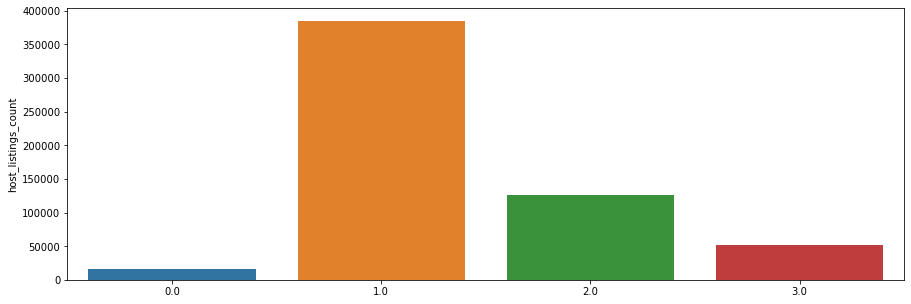

(640364, 23)


In [41]:
grafico_barra(base_airbnb_df['host_listings_count'])
print(base_airbnb_df.shape)

#### bathrooms

<AxesSubplot:ylabel='bathrooms'>

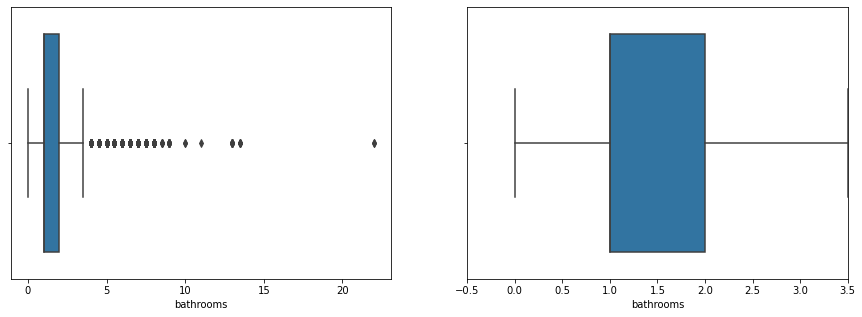

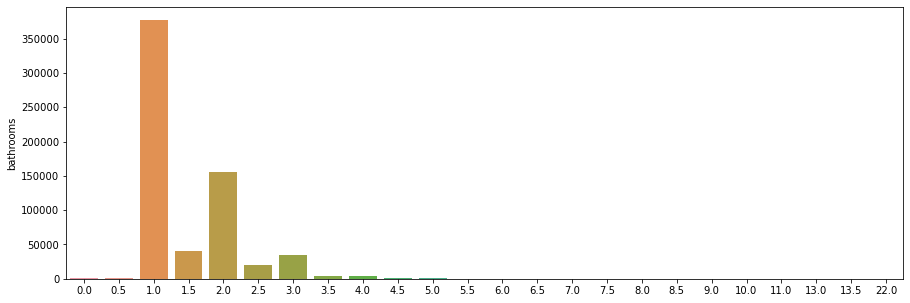

In [42]:
diagrama_caixa(base_airbnb_df['bathrooms'])
plt.figure(figsize=(15,5))
sns.barplot(x=base_airbnb_df['bathrooms'].value_counts().index, y=base_airbnb_df['bathrooms'].value_counts())

In [43]:
base_airbnb_df, linhas_removidas = excluir_outliers(base_airbnb_df, 'bathrooms') #removendo outliers

In [44]:
print('{} linhas removidas'.format(linhas_removidas))

6894 linhas removidas


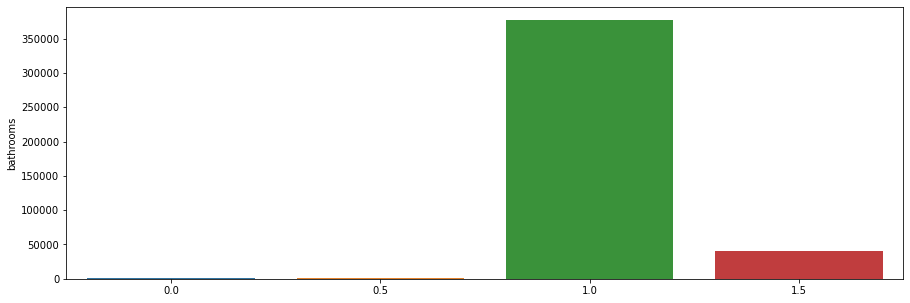

(633470, 23)


In [45]:
grafico_barra(base_airbnb_df['bathrooms'])
print(base_airbnb_df.shape)

#### bedrooms

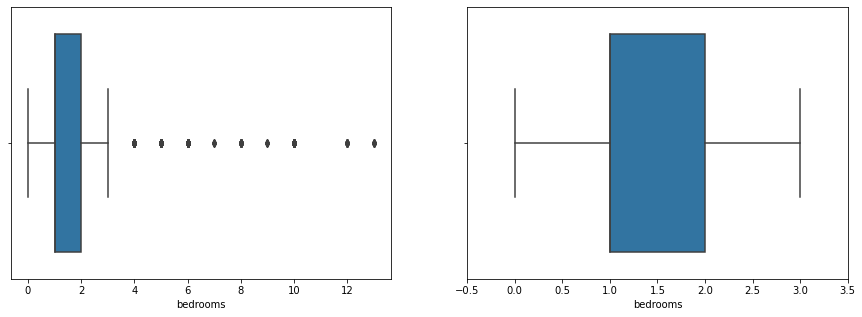

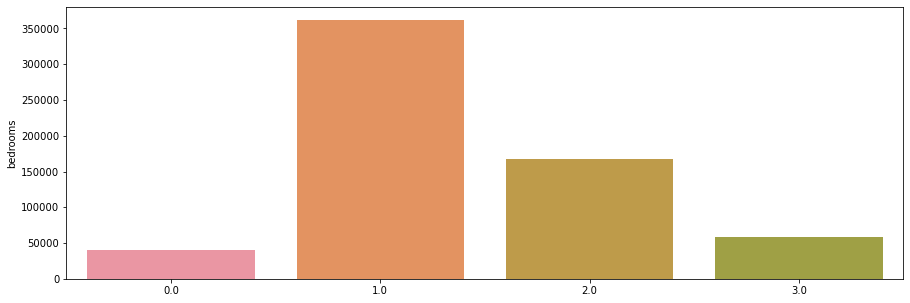

In [46]:
diagrama_caixa(base_airbnb_df['bedrooms'])
grafico_barra(base_airbnb_df['bedrooms'])

In [47]:
base_airbnb_df, linhas_removidas = excluir_outliers(base_airbnb_df, 'bedrooms') #removendo outliers

In [48]:
print('{} linhas removidas'.format(linhas_removidas))

5482 linhas removidas


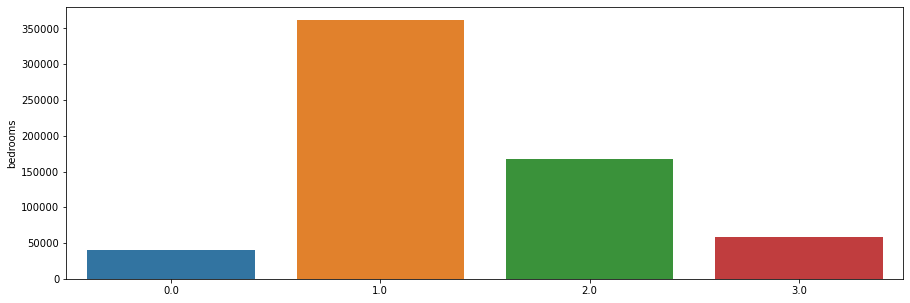

(627988, 23)


In [49]:
grafico_barra(base_airbnb_df['bedrooms'])
print(base_airbnb_df.shape)

#### beds

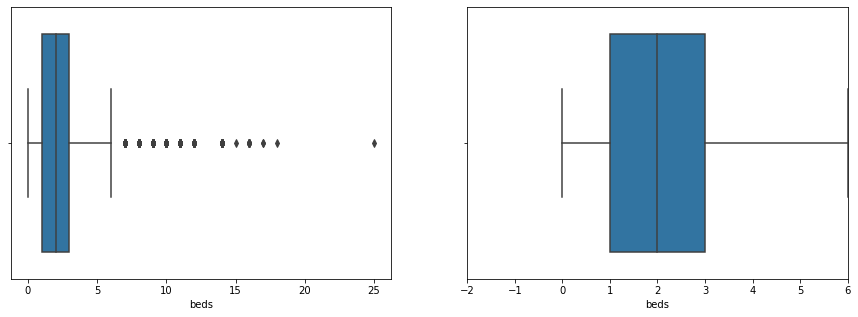

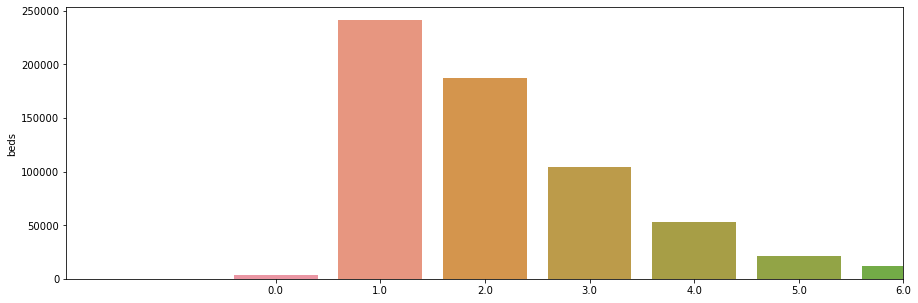

In [50]:
diagrama_caixa(base_airbnb_df['beds'])
grafico_barra(base_airbnb_df['beds'])

In [51]:
base_airbnb_df, linhas_removidas = excluir_outliers(base_airbnb_df, 'beds') #removendo outliers

In [52]:
print('{} linhas removidas'.format(linhas_removidas))

5622 linhas removidas


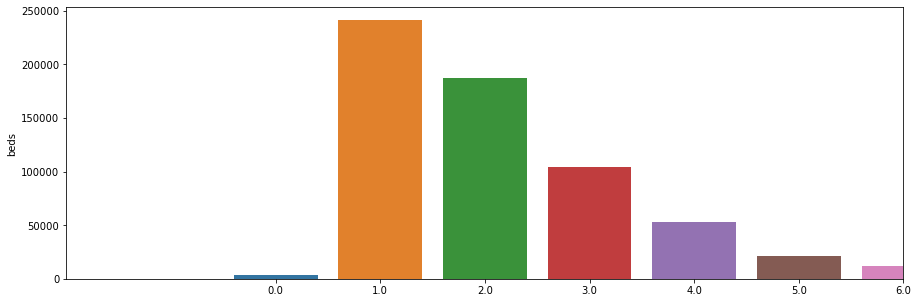

(622366, 23)


In [53]:
grafico_barra(base_airbnb_df['beds'])
print(base_airbnb_df.shape)

#### guests_included

<ipython-input-22-5ada7aafd4fd>:5: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax2.set_xlim(limites(coluna)) # define o limite máximo para o 2 gráfico
<ipython-input-25-a3dfdf72d3a4>:4: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(limites(coluna))


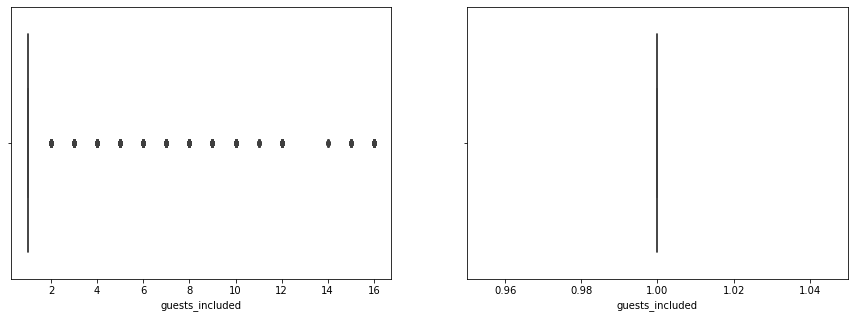

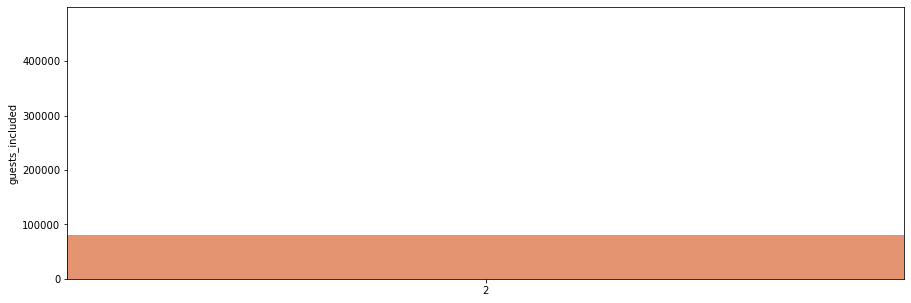

In [54]:
diagrama_caixa(base_airbnb_df['guests_included'])
grafico_barra(base_airbnb_df['guests_included'])

In [55]:
print(limites(base_airbnb_df['guests_included']))

(1.0, 1.0)


<AxesSubplot:ylabel='guests_included'>

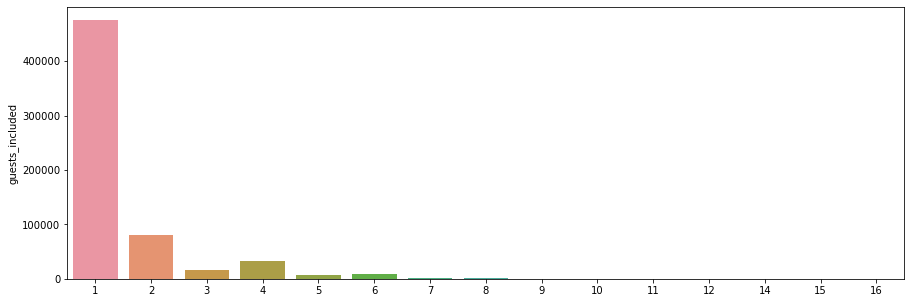

In [56]:
plt.figure(figsize=(15,5))
sns.barplot(x = base_airbnb_df['guests_included'].value_counts().index, y = base_airbnb_df['guests_included'].value_counts())

Parece que a maioria dos usuários incluem só um valor padrão e devemos retirar este dado da análise para tornar o modelo mais eficaz.

In [57]:
base_airbnb_df = base_airbnb_df.drop('guests_included', axis=1)

In [58]:
base_airbnb_df.shape

(622366, 22)

#### minimum_nights

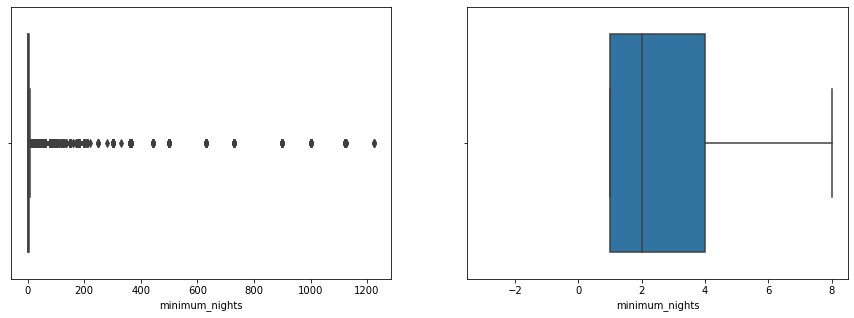

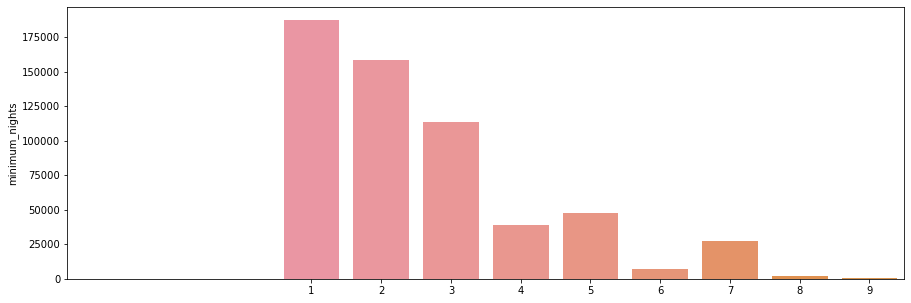

In [59]:
diagrama_caixa(base_airbnb_df['minimum_nights'])
grafico_barra(base_airbnb_df['minimum_nights'])

In [60]:
base_airbnb_df, linhas_removidas = excluir_outliers(base_airbnb_df, 'minimum_nights') #removendo outliers

In [61]:
print('{} linhas removidas'.format(linhas_removidas))

40383 linhas removidas


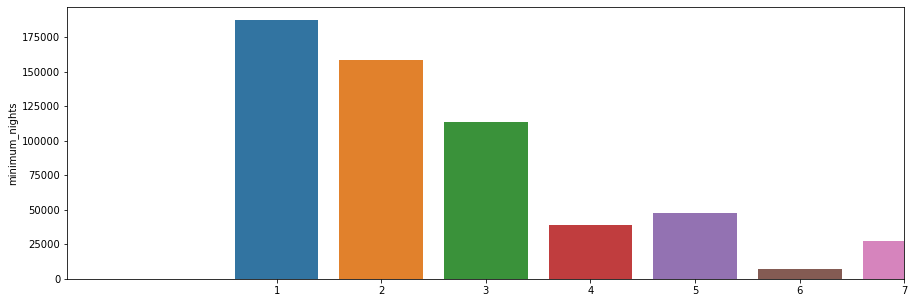

(581983, 22)


In [62]:
grafico_barra(base_airbnb_df['minimum_nights'])
print(base_airbnb_df.shape)

#### maximum_nights

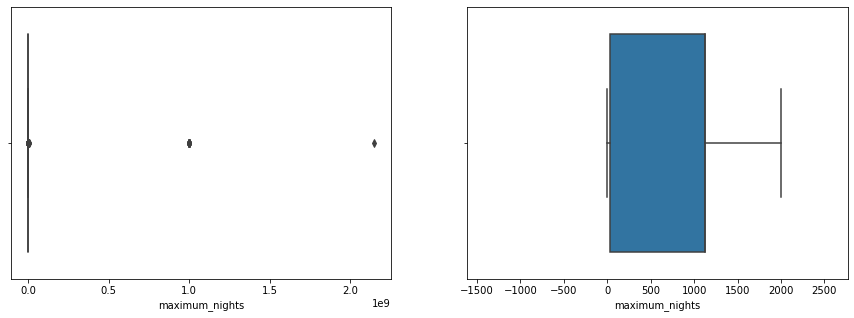

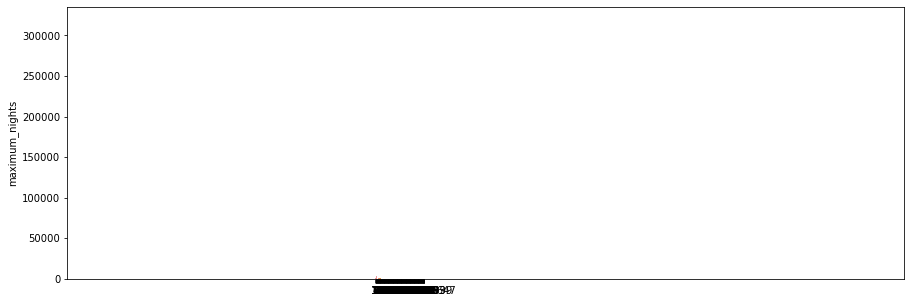

In [63]:
diagrama_caixa(base_airbnb_df['maximum_nights'])
grafico_barra(base_airbnb_df['maximum_nights'])

Parece que os dados foram preenchidos de qualquer forma pelo usuário, então devemos excluir essa coluna para não infuenciar a eficácia da análise.

In [64]:
base_airbnb_df = base_airbnb_df.drop('maximum_nights', axis=1)

In [65]:
base_airbnb_df.shape

(581983, 21)

#### number_of_reviews

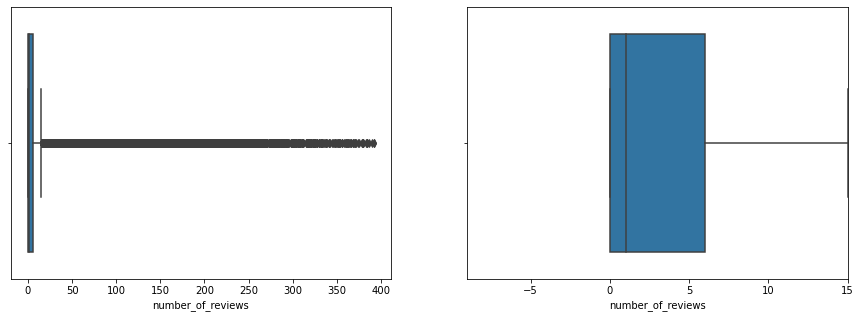

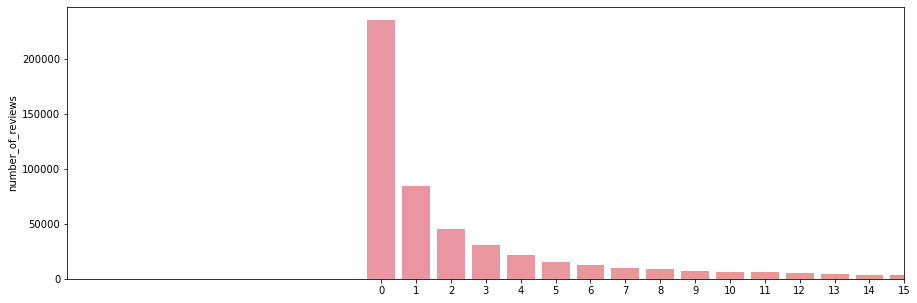

In [66]:
diagrama_caixa(base_airbnb_df['number_of_reviews'])
grafico_barra(base_airbnb_df['number_of_reviews'])

Como a maioria dos imóveis tem poucas avaliações, e como queremos prever o preço. Pela lógica uma pessoa com mais avaliações consegue apurar o preço do aluguel mais acertivamente, justamente por já ter conseguido alugar mais vezes seu imóvel. Neste caso ele já deve ter testado até quanto conseguiu aumentar o valor sem impactar a quantidade de aluguéis.

In [67]:
base_airbnb_df = base_airbnb_df.drop('number_of_reviews', axis=1)

In [68]:
base_airbnb_df.shape

(581983, 20)

### Tratamento de colunas de valores de texto

Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                      34
Resort    

C:\Users\Micro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


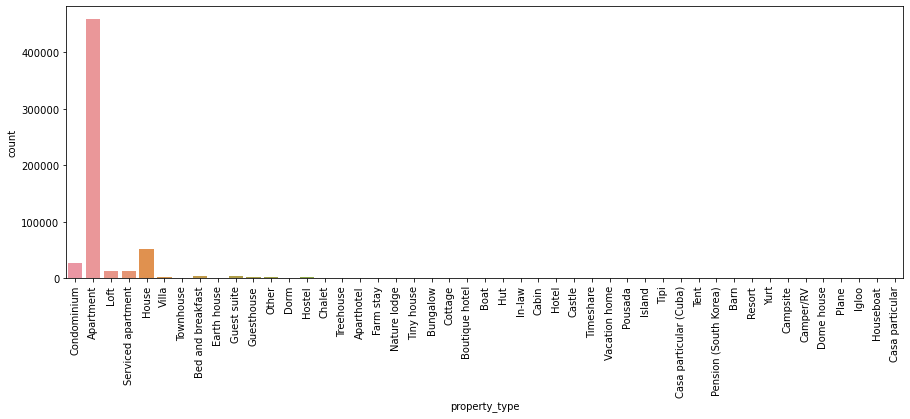

In [69]:
print(base_airbnb_df['property_type'].value_counts())

plt.figure(figsize=(15,5))

grafico = sns.countplot('property_type', data=base_airbnb_df)
grafico.tick_params(axis='x', rotation=90)

In [70]:
tabela_tipo_casa = base_airbnb_df['property_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipo_casa.index:
    if tabela_tipo_casa[tipo] < 2000:
        colunas_agrupar.append(tipo)
    
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb_df.loc[base_airbnb_df['property_type']==tipo, 'property_type'] = 'Outros'
    
print(base_airbnb_df['property_type'].value_counts())

['Other', 'Villa', 'Townhouse', 'Aparthotel', 'Chalet', 'Earth house', 'Tiny house', 'Boutique hotel', 'Hotel', 'Casa particular (Cuba)', 'Cottage', 'Bungalow', 'Dorm', 'Cabin', 'Nature lodge', 'Castle', 'Treehouse', 'Island', 'Boat', 'Hut', 'Campsite', 'Resort', 'Camper/RV', 'Yurt', 'Tent', 'Tipi', 'Barn', 'Farm stay', 'Pension (South Korea)', 'Dome house', 'Igloo', 'In-law', 'Vacation home', 'Houseboat', 'Pousada', 'Timeshare', 'Casa particular', 'Plane']
Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Outros                  8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: property_type, dtype: int64


C:\Users\Micro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


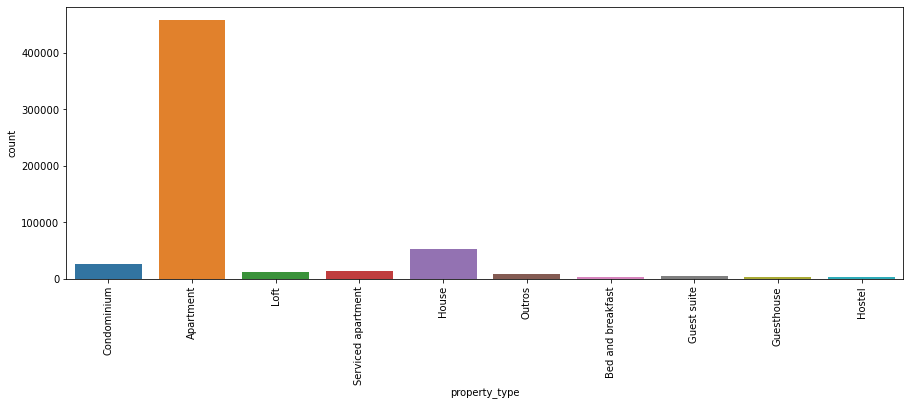

In [71]:
plt.figure(figsize=(15,5))

grafico = sns.countplot('property_type', data=base_airbnb_df)
grafico.tick_params(axis='x', rotation=90)

- room_type

Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: room_type, dtype: int64


C:\Users\Micro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


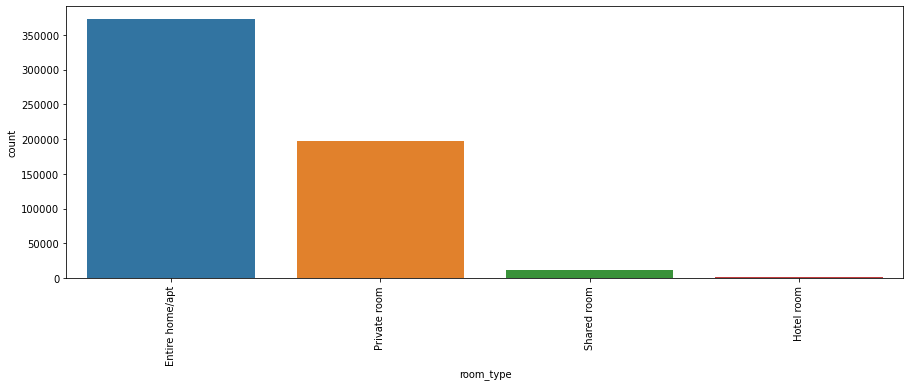

In [72]:
print(base_airbnb_df['room_type'].value_counts())

plt.figure(figsize=(15,5))

grafico = sns.countplot('room_type', data=base_airbnb_df)
grafico.tick_params(axis='x', rotation=90)

- bed_type

Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: bed_type, dtype: int64


C:\Users\Micro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


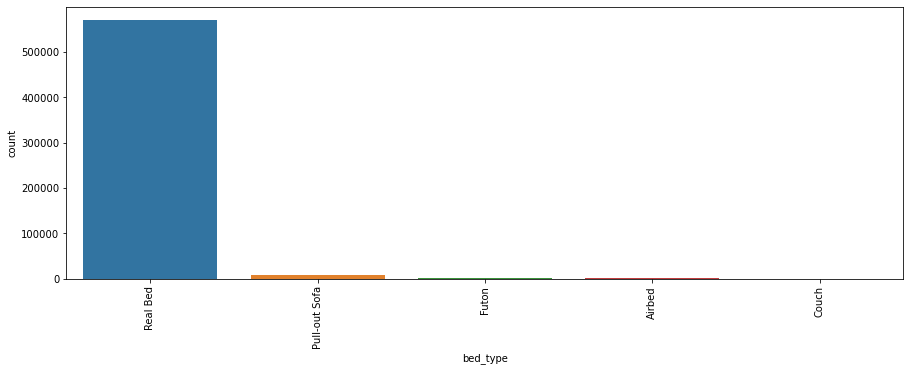

In [73]:
print(base_airbnb_df['bed_type'].value_counts())

plt.figure(figsize=(15,5))

grafico = sns.countplot('bed_type', data=base_airbnb_df)
grafico.tick_params(axis='x', rotation=90)

In [74]:
tabela_tipo_cama = base_airbnb_df['bed_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipo_cama.index:
    if tabela_tipo_cama[tipo] < 8100:
        colunas_agrupar.append(tipo)
    
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb_df.loc[base_airbnb_df['bed_type']==tipo, 'bed_type'] = 'Outras camas'
    
print(base_airbnb_df['bed_type'].value_counts())

['Pull-out Sofa', 'Futon', 'Airbed', 'Couch']
Real Bed        570643
Outras camas     11340
Name: bed_type, dtype: int64


C:\Users\Micro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


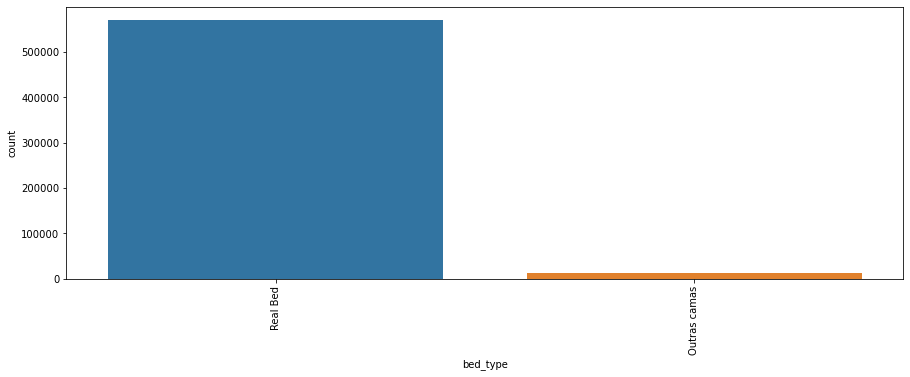

In [75]:
plt.figure(figsize=(15,5))

grafico = sns.countplot('bed_type', data=base_airbnb_df)
grafico.tick_params(axis='x', rotation=90)

- cancellation_policy

flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: cancellation_policy, dtype: int64


C:\Users\Micro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


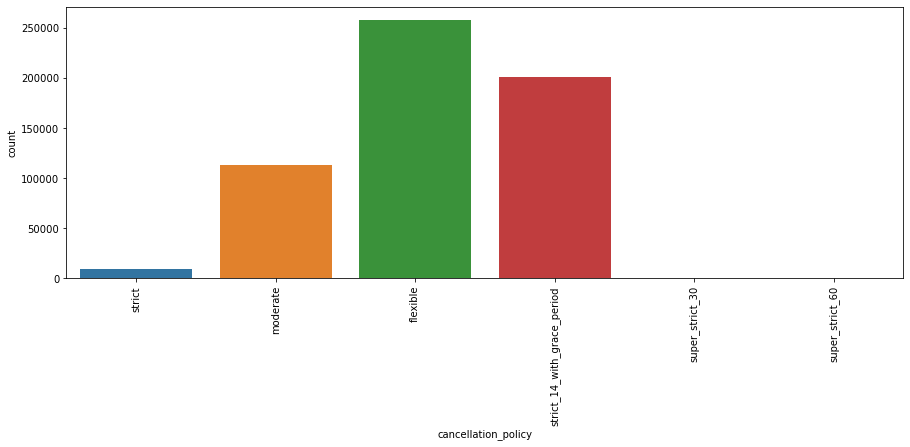

In [76]:
print(base_airbnb_df['cancellation_policy'].value_counts())

plt.figure(figsize=(15,5))

grafico = sns.countplot('cancellation_policy', data=base_airbnb_df)
grafico.tick_params(axis='x', rotation=90)

In [77]:
tabela_tipo_policy = base_airbnb_df['cancellation_policy'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipo_policy.index:
    if tabela_tipo_policy[tipo] < 9700:
        colunas_agrupar.append(tipo)
    
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb_df.loc[base_airbnb_df['cancellation_policy']==tipo, 'cancellation_policy'] = 'strict'
    
print(base_airbnb_df['cancellation_policy'].value_counts())

['strict', 'super_strict_60', 'super_strict_30']
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9863
Name: cancellation_policy, dtype: int64


C:\Users\Micro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


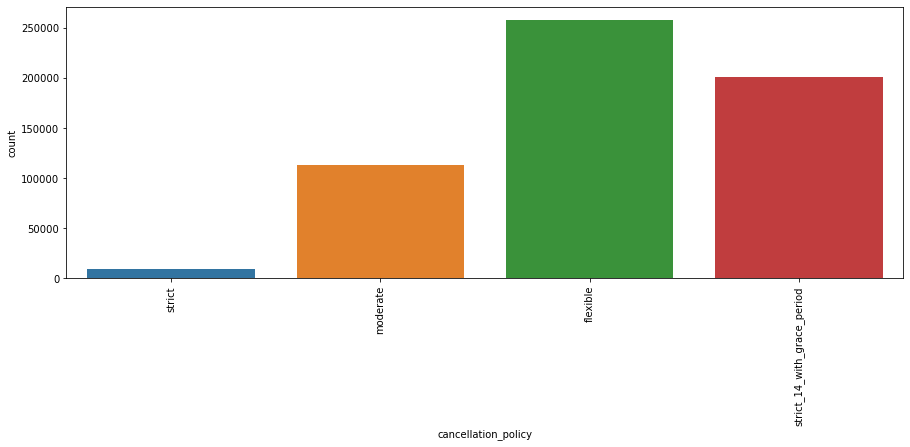

In [78]:
plt.figure(figsize=(15,5))

grafico = sns.countplot('cancellation_policy', data=base_airbnb_df)
grafico.tick_params(axis='x', rotation=90)

- amenities

    Como é um campo de preenchimento livre e temos muitas amenities, vamos considerar somente a quantidade de amenities para ver se isso impacta no preço.

In [79]:
print(base_airbnb_df['amenities'].iloc[1].split(','))
print(len(base_airbnb_df['amenities'].iloc[1].split(',')))

base_airbnb_df['num_amenities'] = base_airbnb_df['amenities'].str.split(',').apply(len)

['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', 'Doorman', 'Elevator', '"Buzzer/wireless intercom"', '"Family/kid friendly"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"}']
14


In [80]:
base_airbnb_df = base_airbnb_df.drop('amenities', axis=1)

In [81]:
base_airbnb_df.shape

(581983, 20)

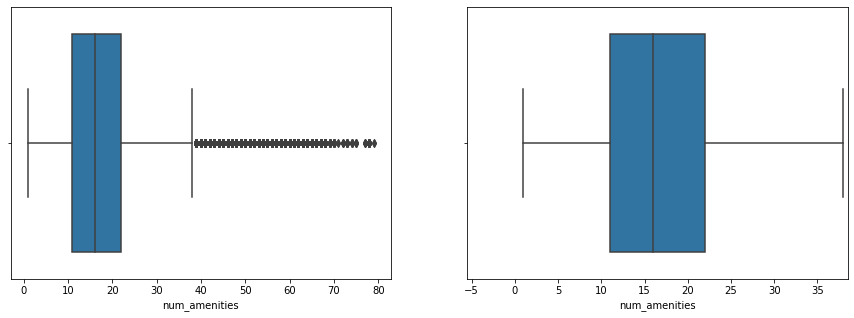

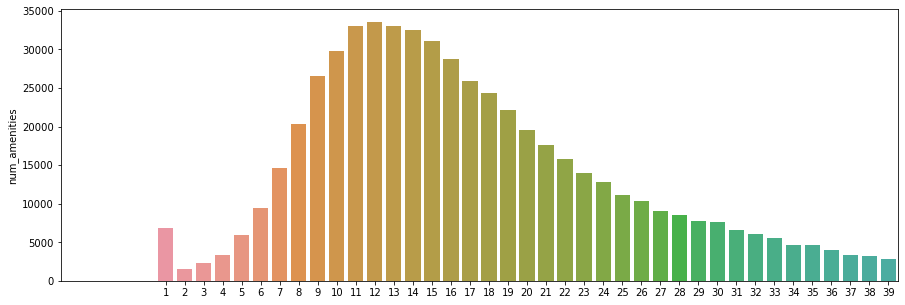

In [82]:
diagrama_caixa(base_airbnb_df['num_amenities'])
grafico_barra(base_airbnb_df['num_amenities'])

In [83]:
base_airbnb_df, linhas_removidas = excluir_outliers(base_airbnb_df, 'num_amenities') #removendo outliers

In [84]:
print('{} linhas removidas'.format(linhas_removidas))

24343 linhas removidas


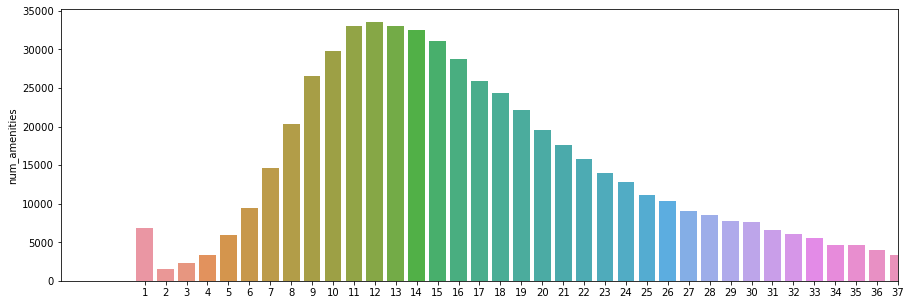

(557640, 20)


In [85]:
grafico_barra(base_airbnb_df['num_amenities'])
print(base_airbnb_df.shape)

### Visualização de Mapa das propriedades

In [86]:
amostra = base_airbnb_df.sample(50000)
centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}

mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude', z='price', radius=2.5,center = centro_mapa, zoom=10,
                       mapbox_style='stamen-terrain')
mapa.show()

### Encoding

Precisamos ajustar as colunas para facilitar o trabalho do modelo (categorias, t/f, etc)

- Colunas com true ou false, vamos substituir por True = 1 e False = 0
- Colunas de categorias (textos) vamos usar variáveis dummies

In [87]:
colunas_tf = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']
colunas_categoria = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']

In [88]:
base_airbnb_df_cod = base_airbnb_df.copy()

In [89]:
for coluna in colunas_tf:
    base_airbnb_df_cod.loc[base_airbnb_df_cod[coluna] == 't', coluna] = 1
    base_airbnb_df_cod.loc[base_airbnb_df_cod[coluna] == 'f', coluna] = 0

In [90]:
base_airbnb_df_cod = pd.get_dummies(data=base_airbnb_df_cod, columns=colunas_categoria)
display(base_airbnb_df_cod.head())

host_is_superhost  host_listings_count   latitude  longitude  accommodates  \
1                 1                  2.0 -22.965919 -43.178962             5   
3                 0                  3.0 -22.977117 -43.190454             3   
4                 1                  1.0 -22.983024 -43.214270             3   
5                 1                  1.0 -22.988165 -43.193588             3   
6                 1                  1.0 -22.981269 -43.190457             2   

   bathrooms  bedrooms  beds  price  extra_people  ...  \
1        1.0       2.0   2.0  270.0          51.0  ...   
3        1.0       1.0   2.0  161.0          45.0  ...   
4        1.0       1.0   2.0  222.0          68.0  ...   
5        1.5       1.0   2.0  308.0          86.0  ...   
6        1.0       1.0   2.0  219.0          80.0  ...   

   room_type_Entire home/apt room_type_Hotel room room_type_Private room  \
1                          1                    0                      0   
3                          1                    0                      0   
4                          1                    0                      0   
5                          1                    0                      0   
6                          1                    0                      0   

   room_type_Shared room  bed_type_Outras camas  bed_type_Real Bed  \
1                      0                      0                  1   
3                      0                      0                  1   
4                      0                      0                  1   
5                      0                      0                  1   
6                      0                      0                  1   

   cancellation_policy_flexible  cancellation_policy_moderate  \
1                             0                             0   
3                             0                             0   
4                             0                             0   
5                             0                             0   
6                             0                             0   

   cancellation_policy_strict  cancellation_policy_strict_14_with_grace_period  
1                           1                                                0  
3                           1                                                0  
4                           1                                                0  
5                           1                                                0  
6                           1                                                0  

[5 rows x 36 columns]

### Modelo de Previsão

- Métricas de Avaliação

In [91]:
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))
    return f'Modelo {nome_modelo}: \nR²:{r2:.2%} \nRSME: {RSME:.2f}'

- Escolha dos modelos a serem testados
    1. RandomForest
    2. LinearRegression
    3. Extra Trees

In [92]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

modelos = {'RandomForest': modelo_rf,
          'LinearRegression': modelo_lr,
          'ExtraTrees': modelo_et,
          }

y = base_airbnb_df_cod['price']
x = base_airbnb_df_cod.drop('price', axis=1)

- Separar em dados de treino e teste

In [93]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 10)

In [94]:
for nome_modelo, modelo in modelos.items():
    #treinar
    modelo.fit(x_train,y_train)
    #testar
    previsao = modelo.predict(x_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest: 
R²:97.24% 
RSME: 44.04
Modelo LinearRegression: 
R²:32.70% 
RSME: 217.54
Modelo ExtraTrees: 
R²:97.49% 
RSME: 42.00


### Análise do Melhor Modelo

In [95]:
for nome_modelo, modelo in modelos.items():
    #testar
    previsao = modelo.predict(x_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest: 
R²:97.24% 
RSME: 44.04
Modelo LinearRegression: 
R²:32.70% 
RSME: 217.54
Modelo ExtraTrees: 
R²:97.49% 
RSME: 42.00


- Modelo escolhido como melhor modelo: ExtraTreesRegressor

Dos 3 modelos foi o que teve melhor R² e RSME.

O RandomForest teve resultados próximos, mas pouco inferiores, e como a velocidade foi próxima, descartamos este modelo.

O LinearRegressor foi o pior modelo com resultados muito piores.

- Resultado das Métricas:<br>

Modelo ExtraTrees: <br>
R²:97.49% <br>
RSME: 42.00

### Ajustes e Melhorias no Melhor Modelo

In [96]:
print(modelo_et.feature_importances_)

[0.0136322  0.0395198  0.10403025 0.10127704 0.07212918 0.06834087
 0.11504253 0.05246459 0.08655223 0.06511087 0.02185562 0.
 0.00472514 0.01132816 0.08914115 0.01246465 0.00129634 0.00509893
 0.0006681  0.00093299 0.00063388 0.00709012 0.00216155 0.00230993
 0.00221592 0.06815734 0.00031002 0.00393599 0.00191176 0.00272716
 0.00259692 0.01945354 0.01229597 0.00086589 0.00772337]


In [97]:
print(x_train.columns)

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'extra_people',
       'minimum_nights', 'instant_bookable', 'is_business_travel_ready', 'mes',
       'ano', 'num_amenities', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House', 'property_type_Loft',
       'property_type_Outros', 'property_type_Serviced apartment',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room',
       'bed_type_Outras camas', 'bed_type_Real Bed',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period'],
      dtype='object')


In [99]:
importancia_features = pd.DataFrame(modelo_et.feature_importances_, x_train.columns)
display(importancia_features)

0
host_is_superhost                                0.013632
host_listings_count                              0.039520
latitude                                         0.104030
longitude                                        0.101277
accommodates                                     0.072129
bathrooms                                        0.068341
bedrooms                                         0.115043
beds                                             0.052465
extra_people                                     0.086552
minimum_nights                                   0.065111
instant_bookable                                 0.021856
is_business_travel_ready                         0.000000
mes                                              0.004725
ano                                              0.011328
num_amenities                                    0.089141
property_type_Apartment                          0.012465
property_type_Bed and breakfast                  0.001296
property_type_Condominium                        0.005099
property_type_Guest suite                        0.000668
property_type_Guesthouse                         0.000933
property_type_Hostel                             0.000634
property_type_House                              0.007090
property_type_Loft                               0.002162
property_type_Outros                             0.002310
property_type_Serviced apartment                 0.002216
room_type_Entire home/apt                        0.068157
room_type_Hotel room                             0.000310
room_type_Private room                           0.003936
room_type_Shared room                            0.001912
bed_type_Outras camas                            0.002727
bed_type_Real Bed                                0.002597
cancellation_policy_flexible                     0.019454
cancellation_policy_moderate                     0.012296
cancellation_policy_strict                       0.000866
cancellation_policy_strict_14_with_grace_period  0.007723

In [100]:
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)

0
bedrooms                                         0.115043
latitude                                         0.104030
longitude                                        0.101277
num_amenities                                    0.089141
extra_people                                     0.086552
accommodates                                     0.072129
bathrooms                                        0.068341
room_type_Entire home/apt                        0.068157
minimum_nights                                   0.065111
beds                                             0.052465
host_listings_count                              0.039520
instant_bookable                                 0.021856
cancellation_policy_flexible                     0.019454
host_is_superhost                                0.013632
property_type_Apartment                          0.012465
cancellation_policy_moderate                     0.012296
ano                                              0.011328
cancellation_policy_strict_14_with_grace_period  0.007723
property_type_House                              0.007090
property_type_Condominium                        0.005099
mes                                              0.004725
room_type_Private room                           0.003936
bed_type_Outras camas                            0.002727
bed_type_Real Bed                                0.002597
property_type_Outros                             0.002310
property_type_Serviced apartment                 0.002216
property_type_Loft                               0.002162
room_type_Shared room                            0.001912
property_type_Bed and breakfast                  0.001296
property_type_Guesthouse                         0.000933
cancellation_policy_strict                       0.000866
property_type_Guest suite                        0.000668
property_type_Hostel                             0.000634
room_type_Hotel room                             0.000310
is_business_travel_ready                         0.000000

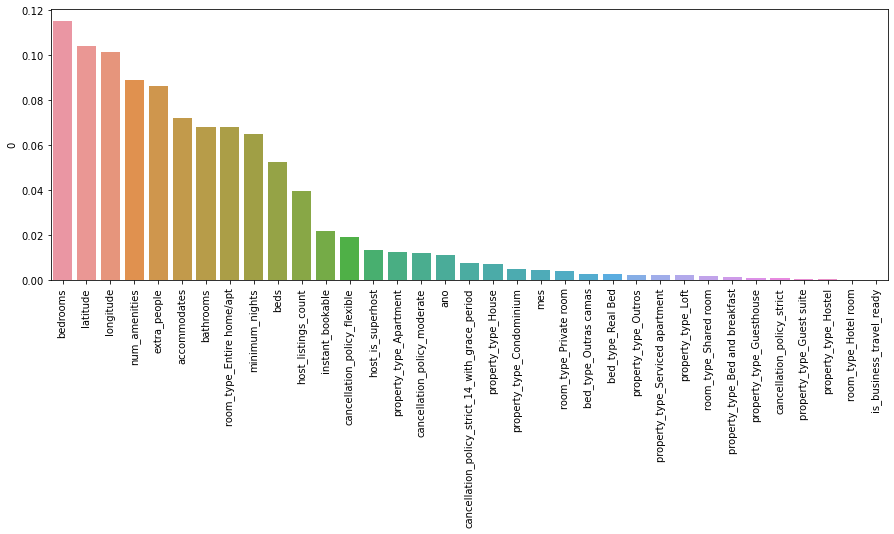

In [104]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation=90)

### Ajustes finais no modelo

- "is_business_travel_ready" não parece ter impacto no modelo. Por isso, para chegar num modelo mais simples, vamos excluir essa feature e testar o modelo sem ela.

In [106]:
base_airbnb_df_cod = base_airbnb_df_cod.drop('is_business_travel_ready', axis=1)

y = base_airbnb_df_cod['price']
x = base_airbnb_df_cod.drop('price', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=10)

modelo_et.fit(x_train, y_train)
previsao = modelo_et.predict(x_test)

print(avaliar_modelo('ExtraTrees',y_test,previsao))

Modelo ExtraTrees: 
R²:97.50% 
RSME: 41.93


- Resultado das Métricas antes do ajuste:<br>

Modelo ExtraTrees: <br>
R²:97.49% <br>
RSME: 42.00 <br>

- Resultado das Métricas depois do ajuste:<br>

Modelo ExtraTrees: <br>
R²:97.50%  <br>
RSME: 41.93

Para testar vou criar uma cópia da base de dados e ver quais colunas posso retirar para melhorar o modelo.

In [107]:
base_teste = base_airbnb_df_cod.copy()

- Teste retirar colunas "bed_type"

In [108]:
for coluna in base_teste:
    if 'bed_type' in coluna:
        base_teste = base_teste.drop(coluna, axis=1)

y = base_teste['price']
x = base_teste.drop('price', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=10)

modelo_et.fit(x_train, y_train)
previsao = modelo_et.predict(x_test)

print(avaliar_modelo('ExtraTrees',y_test,previsao))

Modelo ExtraTrees: 
R²:97.48% 
RSME: 42.07


- Resultado das Métricas antes do ajuste:<br>

Modelo ExtraTrees: <br>
R²:97.50%  <br>
RSME: 41.93 <br>

- Resultado das Métricas depois do ajuste:<br>

Modelo ExtraTrees: <br>
R²:97.48%  <br>
RSME: 42.07

Mesmo piorando um pouco o modelo, podemos considerar retirar essa feature para simplificar o modelo e melhorar um pouco o tempo de processamento.

# Deploy do projeto

- Passo 1 -> Criar arquivo do modelo (joblib)
- Passo 2 -> Escolher a forma de deploy:
        - Arquivo executável + tkinter
        - Deploy em um Microsite (Flask)
        - Deploy apenas para uso direto (Streamlit)
- Passo 3 -> Outro arquivo Python (pode ser Jupyter ou PyCharm)
- Passo 4 -> Importar streamlit e criar código
- Passo 5 -> Atribuir ao botão o carregamento do modelo
- Passo 6 -> Deploy feito

In [109]:
x['price'] = y
x.to_csv('dados.csv')

In [110]:
import joblib
joblib.dump(modelo_et, 'modelo.joblib')

['modelo.joblib']

In [111]:
print(base_teste.columns)

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'extra_people', 'minimum_nights', 'instant_bookable', 'mes', 'ano',
       'num_amenities', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House', 'property_type_Loft',
       'property_type_Outros', 'property_type_Serviced apartment',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period'],
      dtype='object')
